In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
from jax import numpy as jnp
from functools import partial
import optax
import matplotlib.pyplot as plt

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
import plotting
import sim

In [4]:
seed = 42
map_size = 8

# hyperparams
# lr fixed to 1e-3
max_interactions = 256 * 1000
rollout_length = 256  # * (map_size ** 2 --- map_size ** 3)
n_rollouts = max_interactions // rollout_length
train_iter = 8  # *
eps_annealing = optax.cosine_decay_schedule(1.0, train_iter * n_rollouts // 2, 0.1)  # * *

In [5]:
run_simulation = partial(
    sim.run_q_learning_simulation,
    map_size=map_size,
    n_rollouts=n_rollouts,
    rollout_length=rollout_length,
    train_iter=train_iter,
    eps_annealing=eps_annealing,
)
rng_key = jax.random.PRNGKey(seed)
dql_train_state, eval_trans = jax.vmap(run_simulation)(jax.random.split(rng_key, 8))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
rewards, done = eval_trans

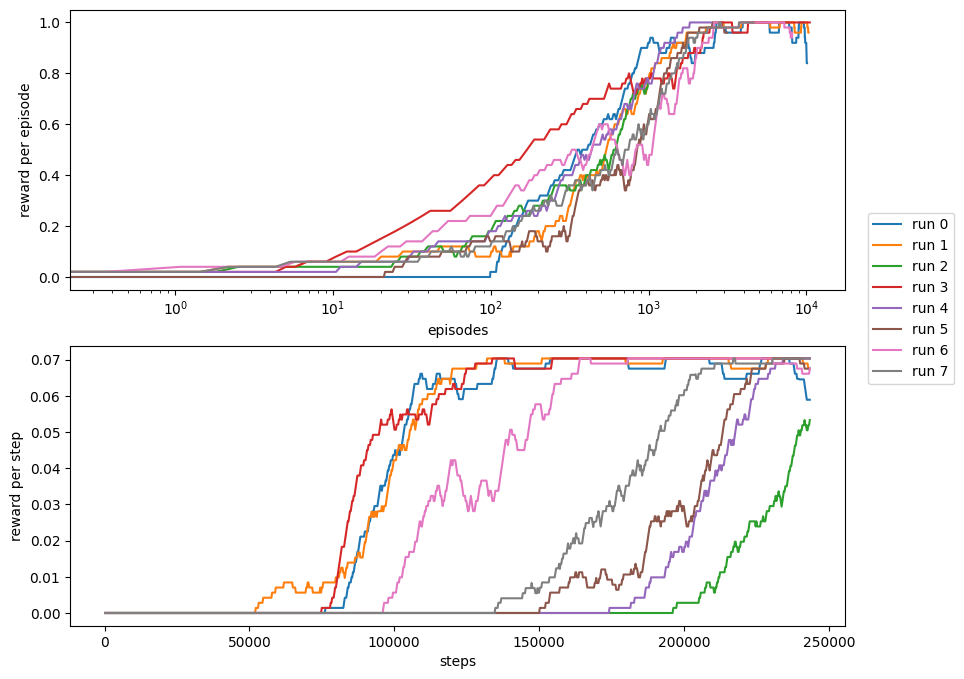

In [7]:
def smooth(r, w=50):
    filter = jnp.ones(w) / w
    return jnp.convolve(r, filter, mode="valid")


avg_done = done.mean(axis=0).sum(axis=-1)
avg_reward = rewards.mean(axis=0).sum(axis=-1)
plt.figure(figsize=(10, 8))
for i, (r, n) in enumerate(zip(rewards.sum(axis=-1), done.sum(axis=-1))):
    plt.subplot(211)
    plt.semilogx(smooth(jnp.cumsum(n)), smooth(jnp.where(n > 0, r / n, 0)), label=f"run {i}")
    plt.ylabel("reward per episode")
    plt.xlabel("episodes")
    plt.subplot(212)
    r = smooth(r) / rewards.shape[-1]
    plt.plot(256*jnp.arange(1,1+len(r)), r, label=f"run {i}")
    plt.ylabel("reward per step")
    plt.xlabel(f"steps")
plt.legend(bbox_to_anchor=(1.15, 1.5))

In [8]:
get_qval = lambda p, o: jax.vmap(qnet.apply, in_axes=(0, None))(p, o).mean(axis=0)

batch_rollout = jax.vmap(partial(rollout, rng_key=rng_key, epsilon=0.0, n_steps=30))
transitions = batch_rollout(dql_state.params)
print(transitions.done.shape)
for tot_reward, n_episodes in zip(transitions.reward.sum(axis=-1), transitions.done.sum(axis=-1)):
    print(f"{int(100*tot_reward/n_episodes)}% success" if n_episodes > 0 else "No success")
 
transitions = jax.tree_map(lambda x: x.reshape(-1, *x.shape[2:]), transitions)
plotting.plot_qvals(env, get_qval, dql_state.params)
plotting.render(env, transitions.env_state)

NameError: name 'rollout' is not defined

: 